# Calculate Diffusion Coefficient

The 1-dim cage-to-cage hopping rate is given by: 
$$ k_{C_1 \rightarrow C_2} = \kappa \sqrt{\frac{k_B T}{2 \pi m}} \frac{e^{-\beta F(q^*)}}{\int_{cage} e^{-\beta F(q)} \,dq} $$
where m is the mass of the adsorbate, q is the reaction coordinate, F is the SOMETHING Free Energy as a function of the reaction coordinate, T is the temperature (T = 298 K), and $\kappa$ is the Bennett-Chandler dynamic correction. $\kappa$ = 1 is a good approximatin for infinite dilution. 
The space is partitioned such that the dividing surface is perpendicular to the reactin coordinate and passes through the location of the maximum free energy barrier along the path F(q*). 


To get the self-diffusion coefficient ($D_s$) 
$$ D_s = \frac{\kappa}{2d} \lambda^2 k_{C_1 \rightarrow C_2} $$

$\lambda$ is the cage-center to cage-center lattice distance.

### Outline
In this notebook, I am going to try to implement Transition State Theory (TST) to calculate the Self-Diffusion Coefficient of Xe and Kr in Ni(PyC)2 and Ni(PyC-m-NH2)2.

Helpful references include:
   1. [J. Phys. Chem. C 2016, 120, 2, 1110–1120](https://doi.org/10.1021/acs.jpcc.5b11111)
   2. [J. Chem. Phys. 122, 224712 (2005)](https://doi.org/10.1063/1.1924548)
   
Strategy:
   1. Load crystal, molecules, forcefield, ... 
   2. Perform `energy_grid()` calculation on each scructure for each adsorbate
   3. Define the reaction coordinate 
       a) find the location of the minimum free energy
       b) find the location of the minimum free energy in an adjacent pocket.
   4. Take "slices" of the free energy profile along the reaction coordinate.
   5. Perform integration using julia package [Cubature.jl](https://github.com/JuliaMath/Cubature.jl)
   6. Calculate cage-to-cage hopping rate $k_{C_1 \rightarrow C_2}$
   7. Calculate sel-difusion coefficient $D_s$

In [1]:
using PorousMaterials
using PyPlot
using Cubature

┌ Warning: Error requiring `OffsetArrays` from `ArrayInterface`
│   exception = (UndefVarError(:IdOffsetRange), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f567e835cef, Ptr{Nothing} @0x00007f567e8c8d24, Ptr{Nothing} @0x00007f5670653da2, Ptr{Nothing} @0x00007f567e8ab769, Ptr{Nothing} @0x00007f567e8c7f15, Ptr{Nothing} @0x00007f567e8c7bce, Ptr{Nothing} @0x00007f567e8c8811, Ptr{Nothing} @0x00007f567e8c9297, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 11, Ptr{Nothing} @0x00007f567e8e4b31, Ptr{Nothing} @0x00007f567e8e6949, Ptr{Nothing} @0x00007f561f57f2a1, Ptr{Nothing} @0x00007f561f57f2cc, Ptr{Nothing} @0x00007f567e8ab769, Ptr{Nothing} @0x00007f567e8c7f15, Ptr{Nothing} @0x00007f567e8c7bce, Ptr{Nothing} @0x00007f567e8c8811, Ptr{Nothing} @0x00007f567e8c8b90, Ptr{Nothing} @0x00007f567e8c904a, Base.InterpreterIP in MethodInstance for err(::Any, ::Module, ::String) at statement 2, Ptr{Nothing} @0x00007f561f57f217, Ptr{Nothing} @0x00007f561f57f22c, Ptr

In [2]:
xtals     = [Crystal("NiPyC2_experiment.cif"), Crystal("Pn_Ni-PyC-NH2.cif")]
rep_factors  = [(2, 1, 1), (1, 1, 2)]
rep_xtals = [replicate(xtals[1], rep_factors[1]), replicate(xtals[2], rep_factors[2])]

adsorbates = [Molecule("Xe"), Molecule("Kr")]

temp = 298.0 # temperature, units: K
const R = 8.31446261815324 / 1000 # ideal gas constant, units: kJ/(mol-K)
ljff = LJForceField("UFF");

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433
┌ Info: Crystal Pn_Ni-PyC-NH2.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433


**Use info from accessibility grid to determine reaction coordinate**

In [3]:
# for xtal in rep_xtals
#     accessibility_grid, nb_segments_blocked, porosity = compute_accessibility_grid(xtal, adsorbates[1], ljff; 
#                                                                             resolution=0.5, 
#                                                                             energy_tol=25.0, 
#                                                                             energy_units=:kJ_mol, 
#                                                                             verbose=true, 
#                                                                             write_b4_after_grids=false, 
#                                                                             block_inaccessible_pockets=true)
# end

In [3]:
# grid.box      # Bravais lattice over which a grid of points is superimposed
# grid.data     # 3 dim array containing data for each point
# grid.n_pts    # number of grid points in x, y, z
# grid.origin   # the origin of the grid
# grid.units    # units associated with each data point
res  = 0.2 # maximum distance between grid points, units: Å
grid = energy_grid(rep_xtals[1], adsorbates[1], ljff, resolution=res, units=:kJ_mol) 

# get estimate for location of energy minimum on a grid to use as initial estimate 
grd_min_mol, grd_min_E = find_energy_minimum_gridsearch(rep_xtals[1], adsorbates[1], ljff, resolution=res)

# find location of the energy minimum 
# this will be used as the origin of the vector describing the reaction coordinate
minimized_molecule, minimum_E = find_energy_minimum(rep_xtals[1], grd_min_mol, ljff)

# get the voxel ID for the location of the energy minimum
xf = [minimized_molecule.com.xf[i] for i in 1:3]
vox_id = xf_to_id(grid.n_pts, xf)

Computing energy grid of Xe in NiPyC2_experiment.cif
	Regular grid (in fractional space) of 64 by 64 by 53 points superimposed over the unit cell.
Computing energy grid of Xe in NiPyC2_experiment.cif
	Regular grid (in fractional space) of 64 by 64 by 53 points superimposed over the unit cell.


3-element Vector{Int64}:
 63
 46
 19

In [5]:
# calculate the free energy at every grid point
function calc_free_energy(grid::Grid)
    β = 1 / (R * temp)
    return exp.(-1.0 * β * grid.data)
end

free_energy_grid = calc_free_energy(grid::Grid);

In [ ]:
emax_on_q = maximum(free_energy_grid[:, vox_id[2], vox_id[3]])

In [6]:
loc_q_max = findfirst(free_energy_grid[:, vox_id[2], vox_id[3]] .== 
                      maximum(free_energy_grid[:, vox_id[2], vox_id[3]]))

63

In [23]:
emin_on_q = minimum(free_energy_grid[:, vox_id[2], vox_id[3]])

0.022642083422670486

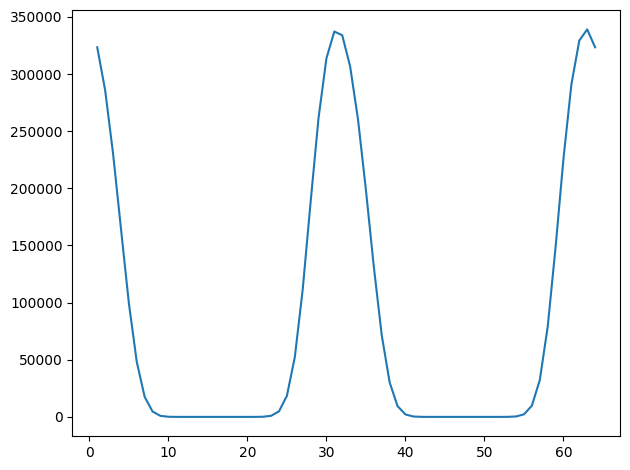

In [22]:
figure()
x = [i for i in 1:grid.n_pts[1]]
plot(x, free_energy_grid[:, vox_id[2], vox_id[3]])
tight_layout()

In [5]:
# fractional cordinates
qmin = 0.0
qmax = 1.0

function integrand(q::Float64, rep_factors::Tuple{Int, Int, Int})
    # get voxel ID for reaction coordinate
    # recall: xf = [minimized_molecule.com.xf[i] for i in 1:3]
    q_id = xf_to_id(grid.n_pts, [q, xf[2], xf[3]])
    @assert q_id[2] == vox_id[2]
    @assert q_id[3] == vox_id[3]
    # get energy at that grid point
    grid_energy = grid.data[q_id[1], q_id[2], q_id[3]] # units: kJ/mol
    # calculte Boltzman factor 
    beta = 1.0 / (R * temp) # units: kJ/mol
    boltzman_factor = exp(-1.0 * beta * grid_energy)
    return boltzman_factor
end


# perform 1-dim integration 
(val, err) = hquadrature(q -> begin integrand(q, reps); end, qmin, qmax; 
                         reltol=1e-8, abstol=0, maxevals=0) 

(68881.01039609025, 0.0006751412077463042)

# Plots

Plot the energy along a given crystal axis.

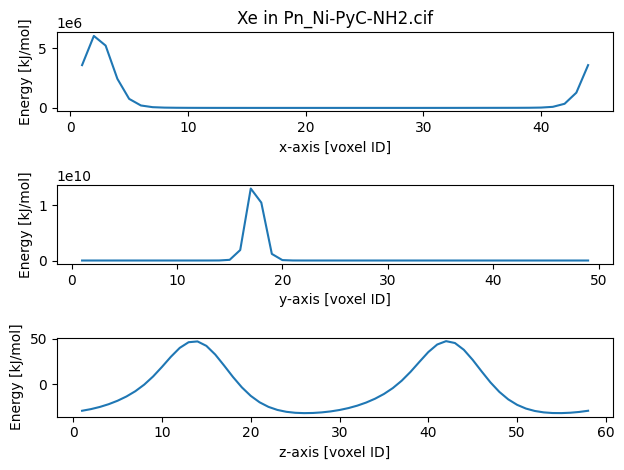

In [5]:
function plot_energy_on_reaction_coord(xtal::Crystal, adsorbate::Molecule{Cart})
    fig, axs = subplots(3)

    x = [i for i in 1:grid.n_pts[1]]
    y = [i for i in 1:grid.n_pts[2]]
    z = [i for i in 1:grid.n_pts[3]]

    # plot along x-axis
    axs[1].plot(x, grid.data[:, vox_id[2], vox_id[3]])
    axs[1].set_xlabel("x-axis [voxel ID]")
    axs[1].set_ylabel("Energy [kJ/mol]")
    axs[1].set_title("$(String(adsorbate.species)) in $(xtal.name)")

    # plot along y-axis
    axs[2].plot(y, grid.data[vox_id[1], :, vox_id[3]])
    axs[2].set_ylabel("Energy [kJ/mol]")
    axs[2].set_xlabel("y-axis [voxel ID]")
    # axs[2].set_ylim(ymax=5000)

    # plot along z-axis
    axs[3].plot(z, grid.data[vox_id[1], vox_id[2], :]) # max ~70000
    axs[3].set_ylabel("Energy [kJ/mol]")
    axs[3].set_xlabel("z-axis [voxel ID]")

    fig.tight_layout()
    savefig(joinpath(pwd(), "energygrid_slices", 
            "energy_contour_$(String(adsorbate.species))_in_$(split(xtal.name, '.')[1]).png"), 
            dpi=600, format="png")
    fig.show()
end

plot_energy_on_reaction_coord(xtal, adsorbate)

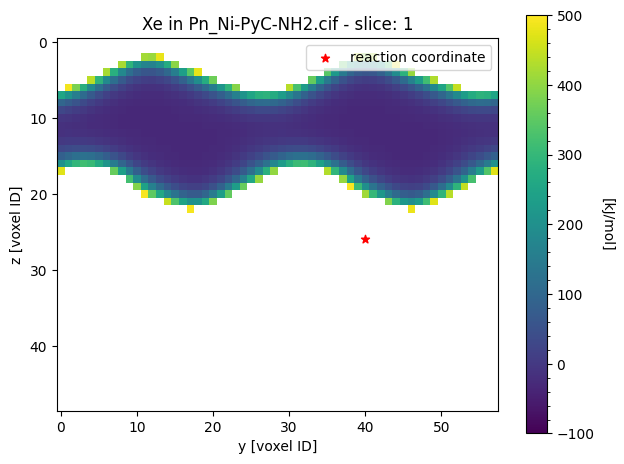

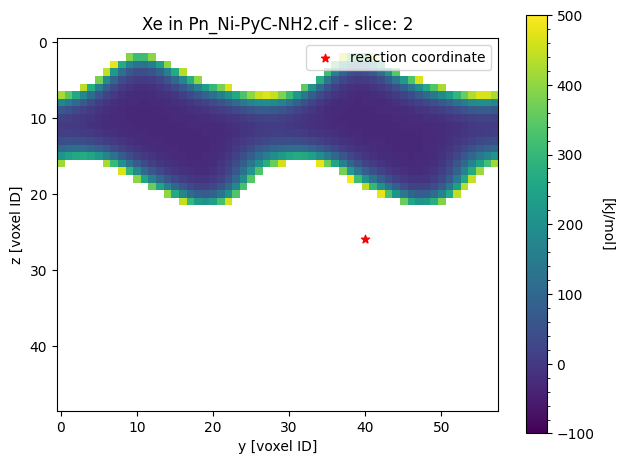

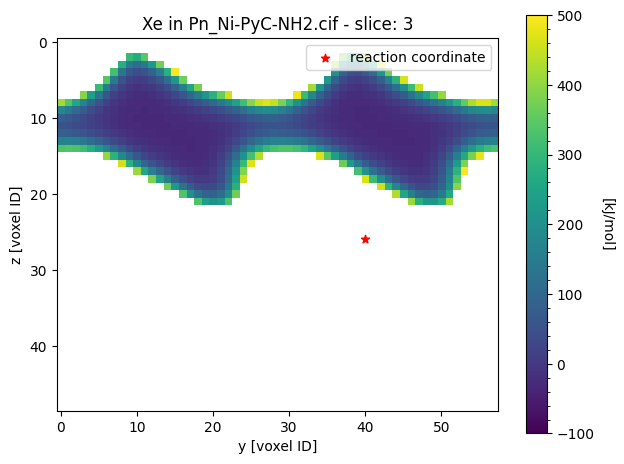

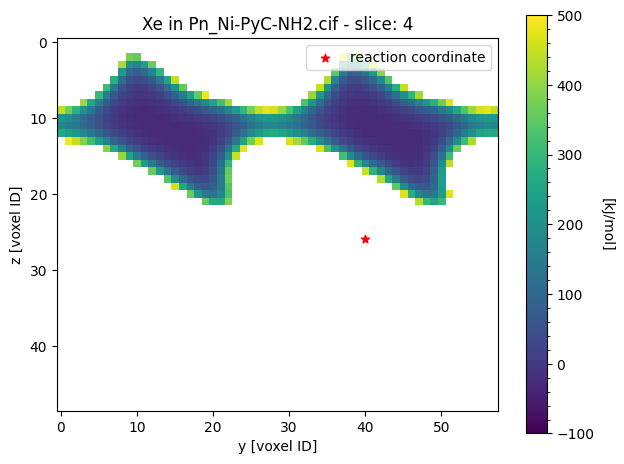

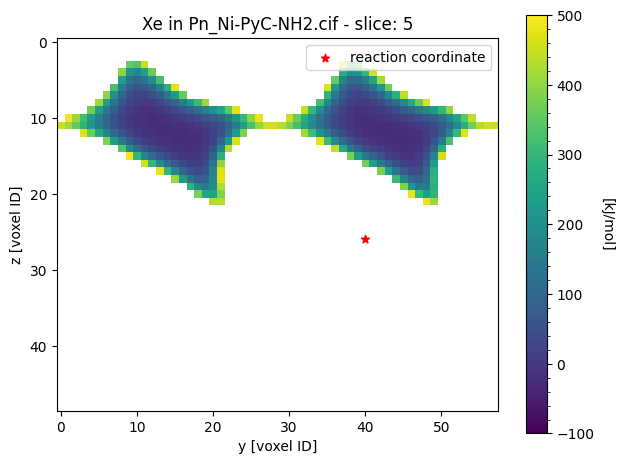

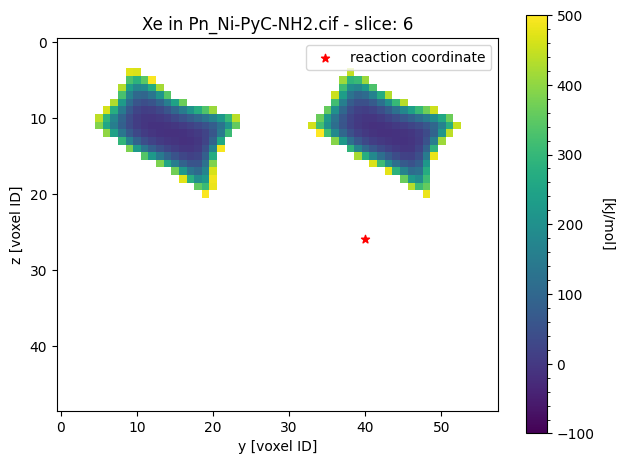

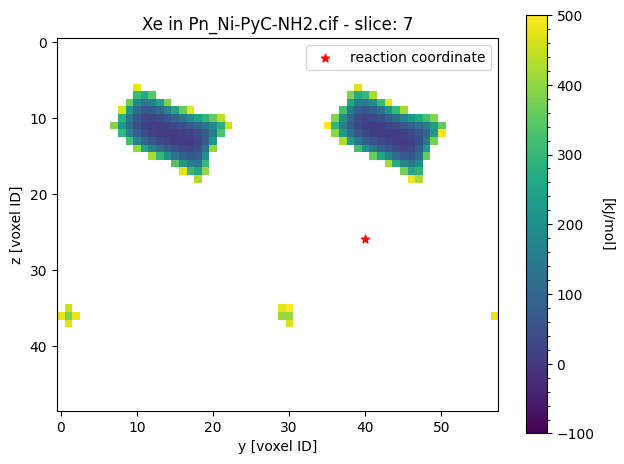

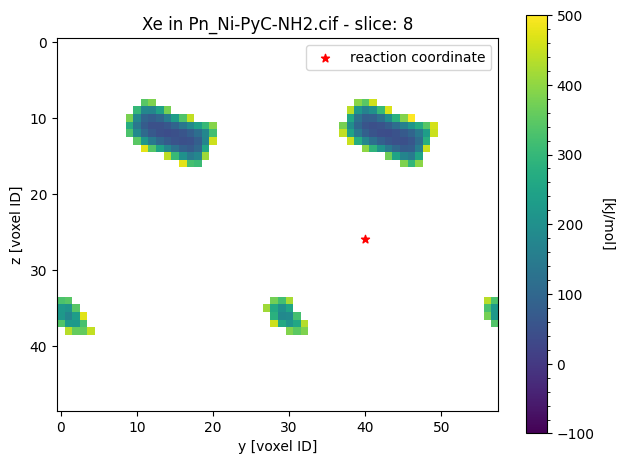

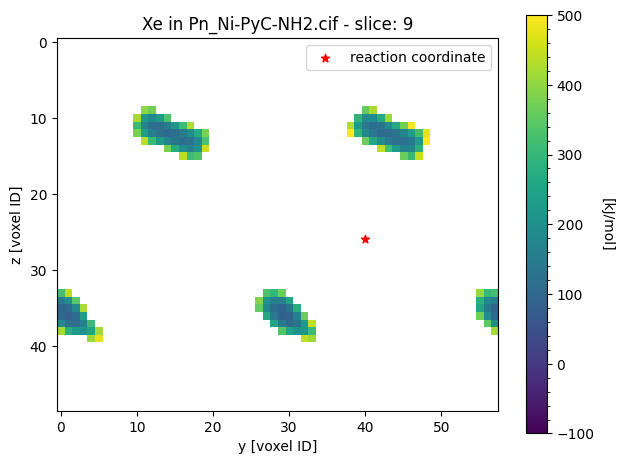

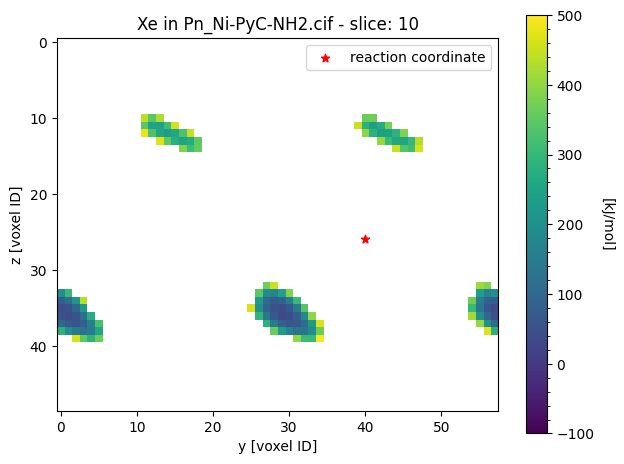

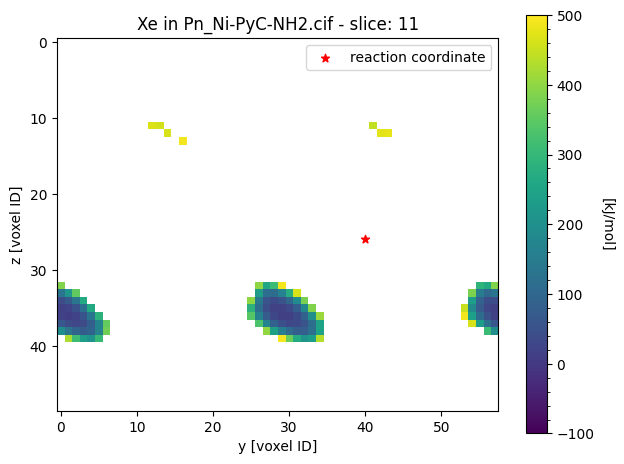

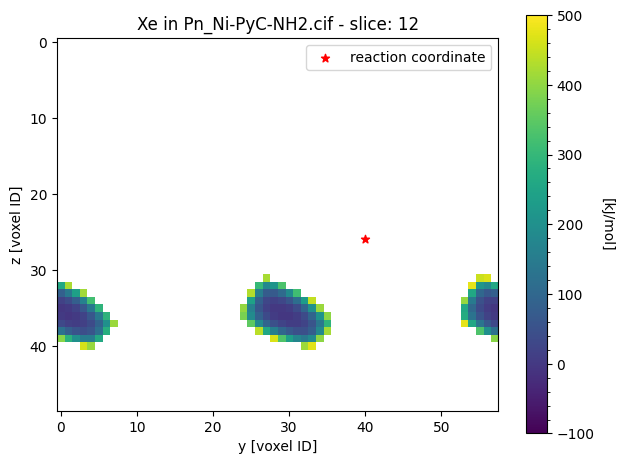

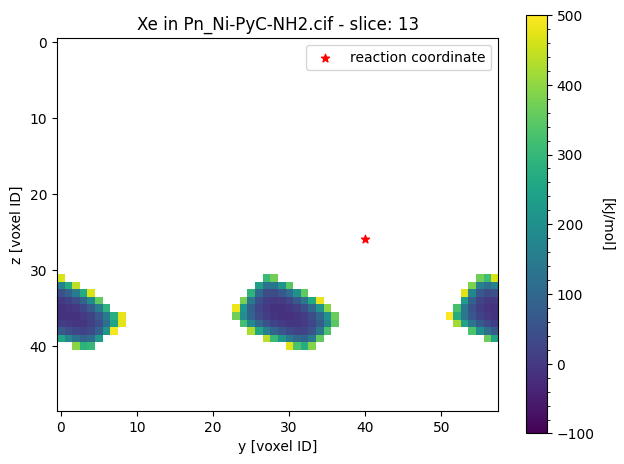

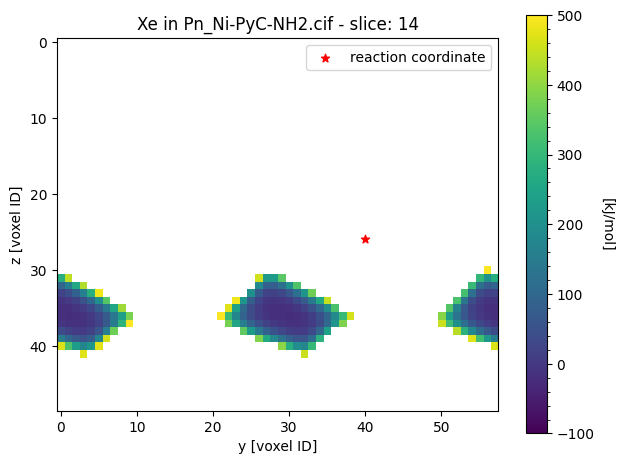

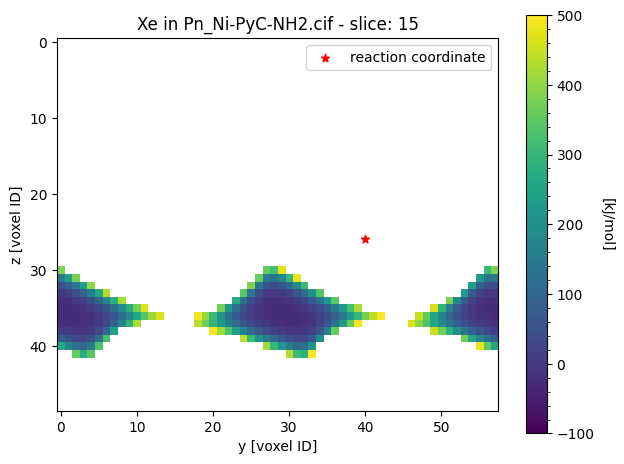

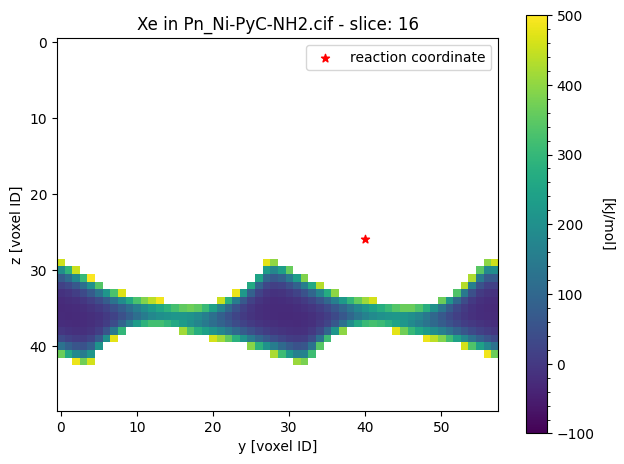

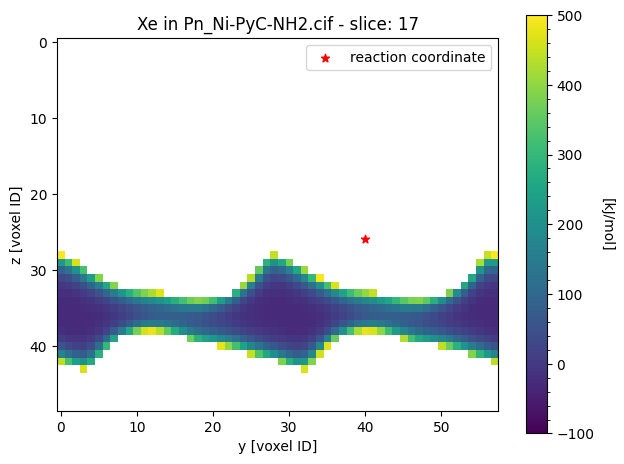

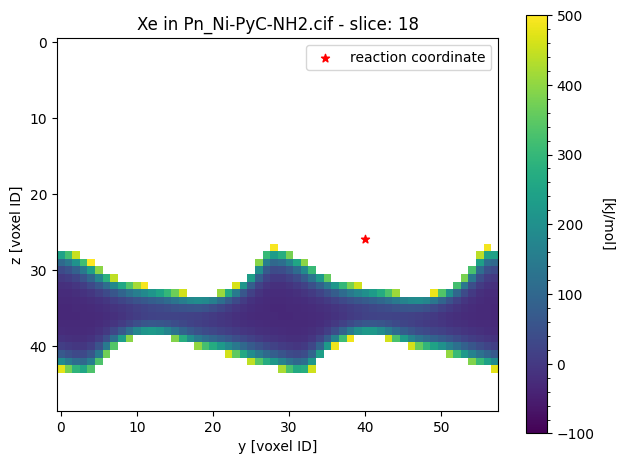

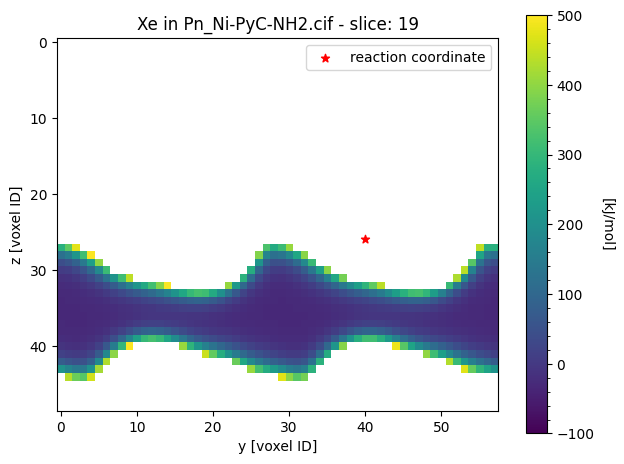

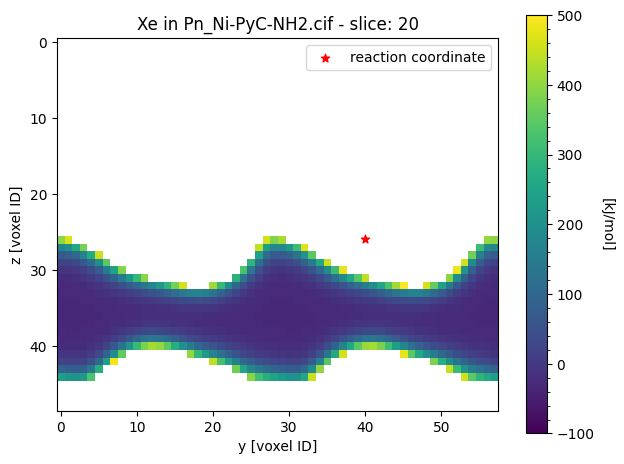

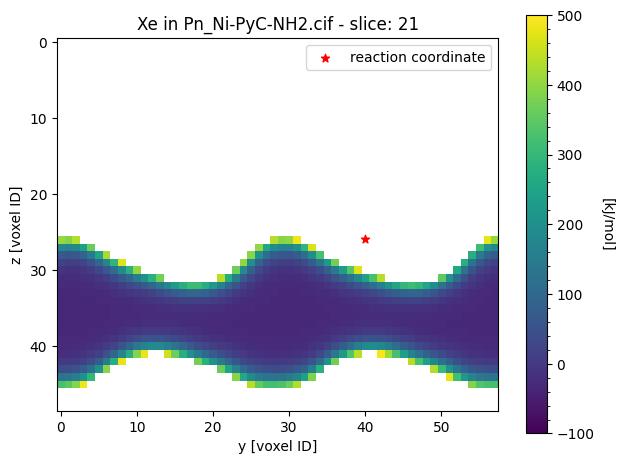

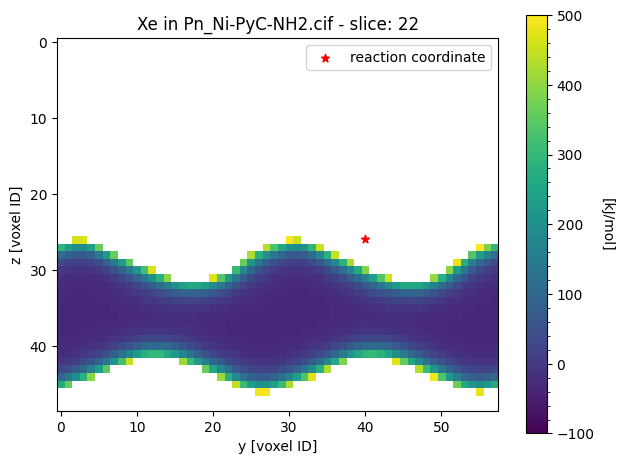

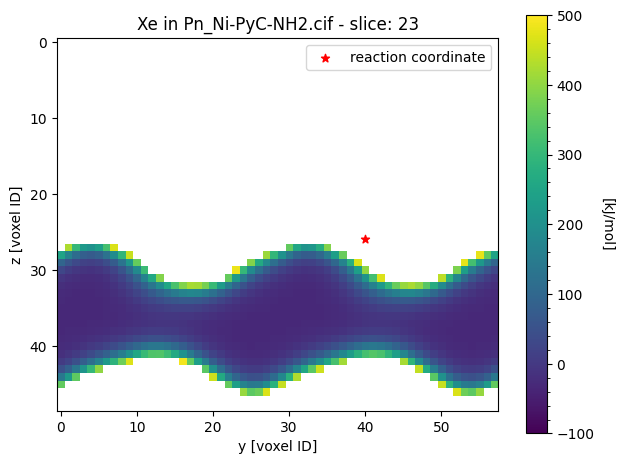

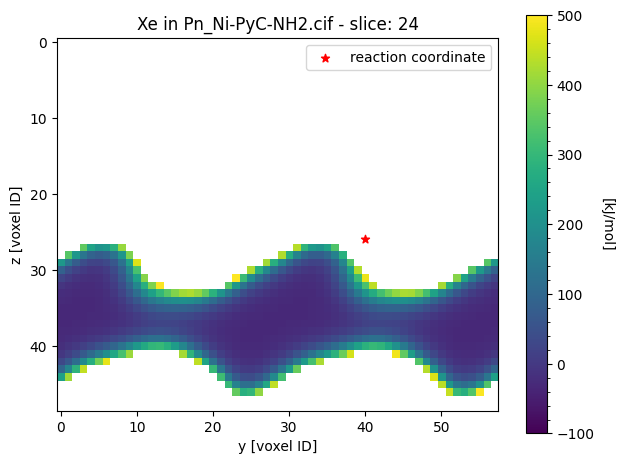

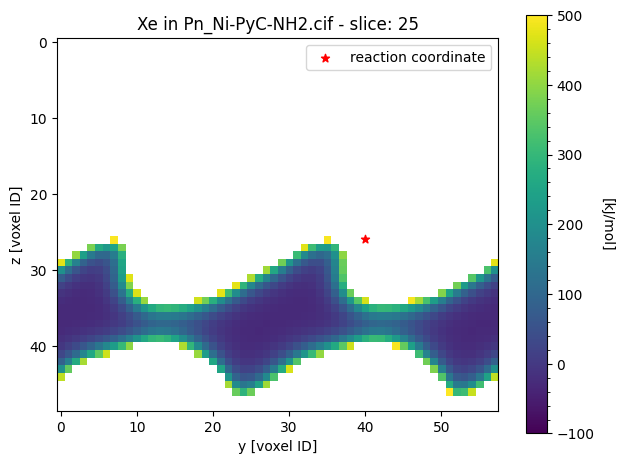

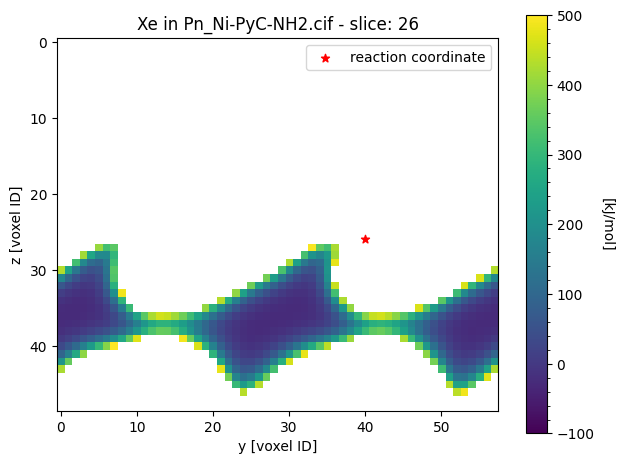

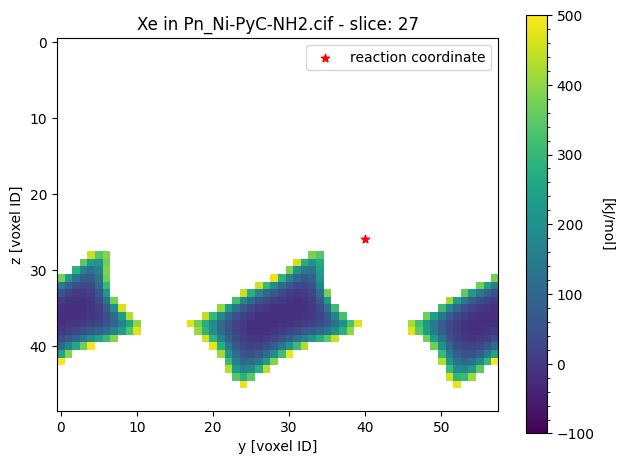

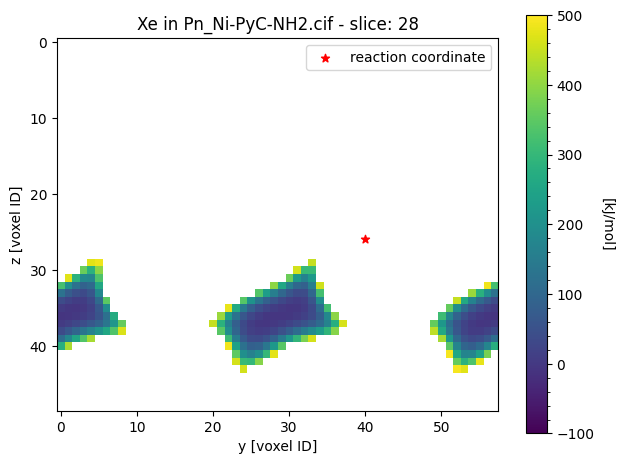

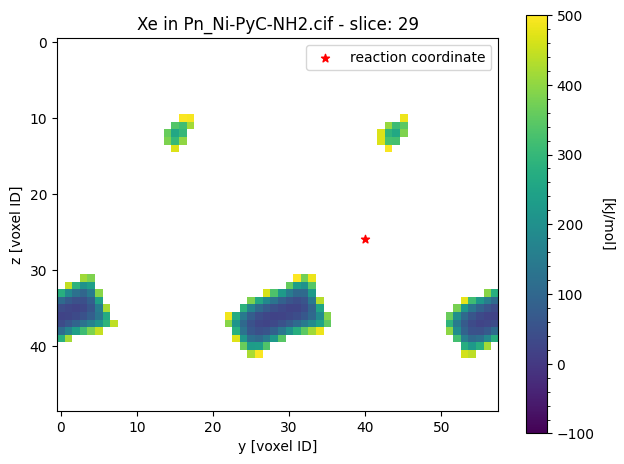

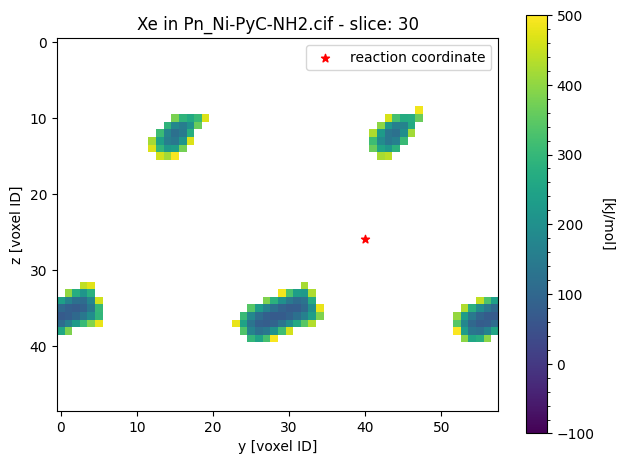

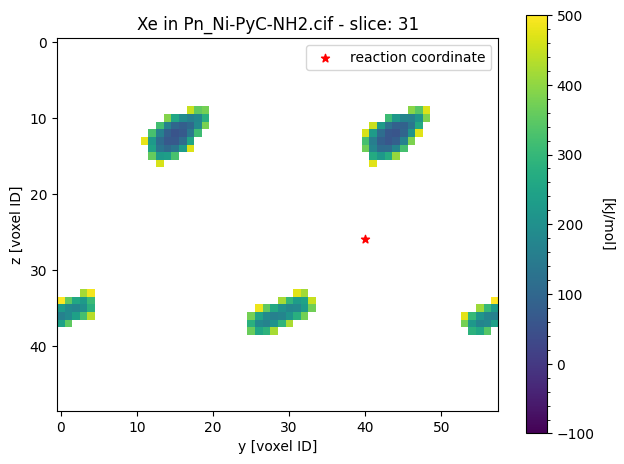

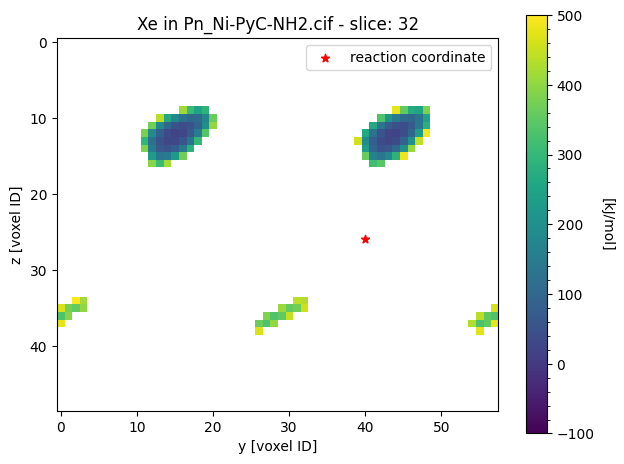

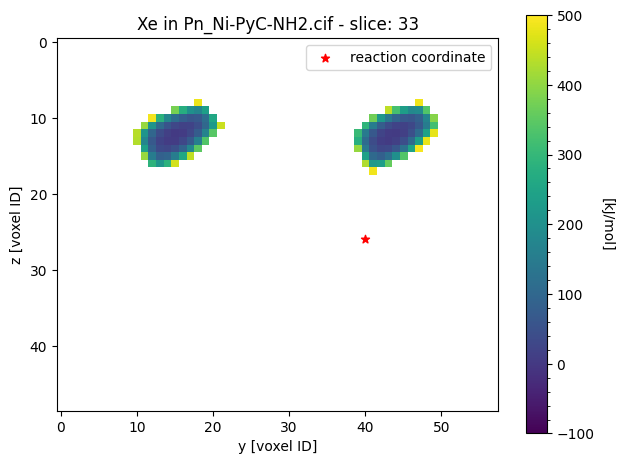

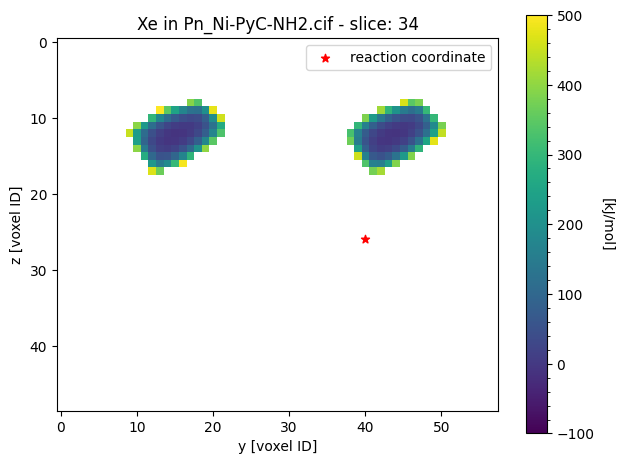

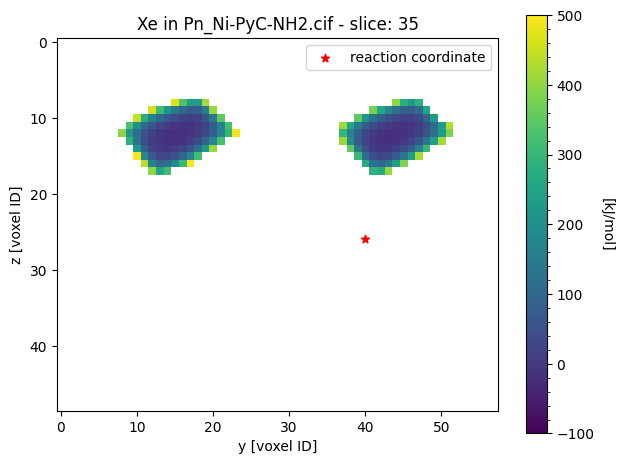

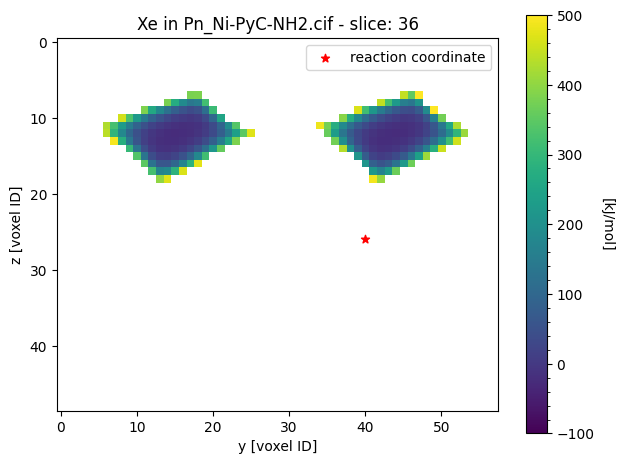

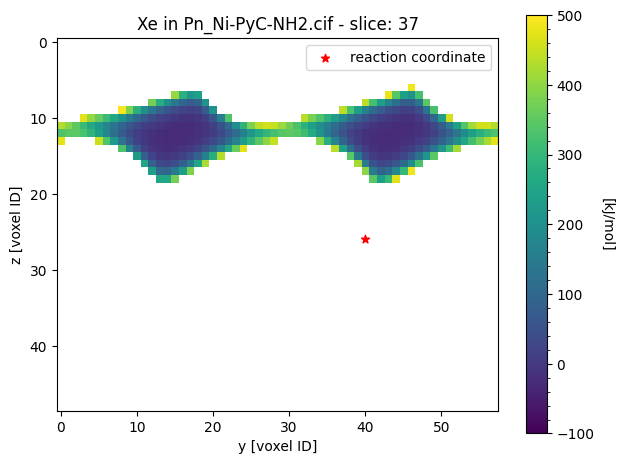

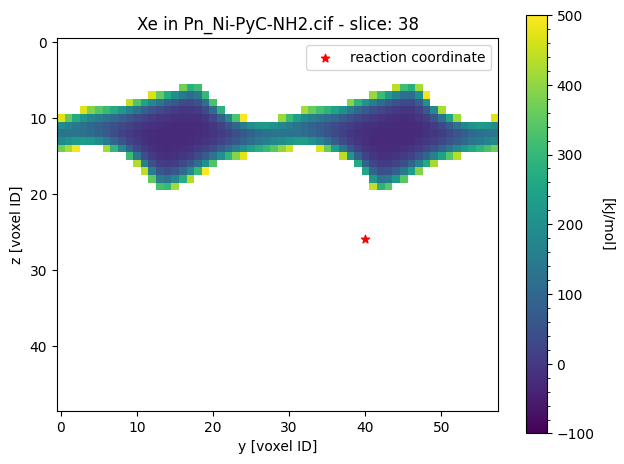

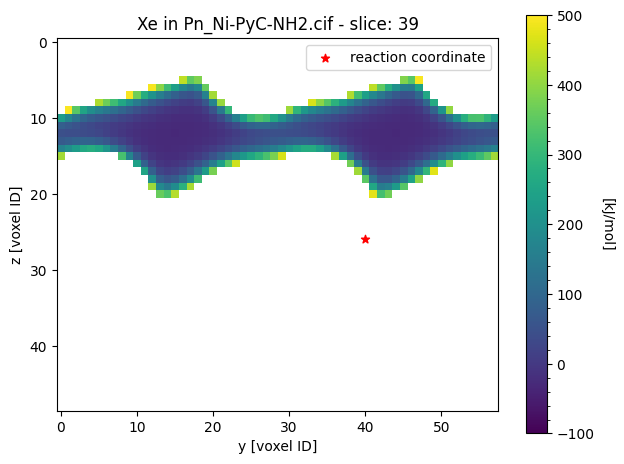

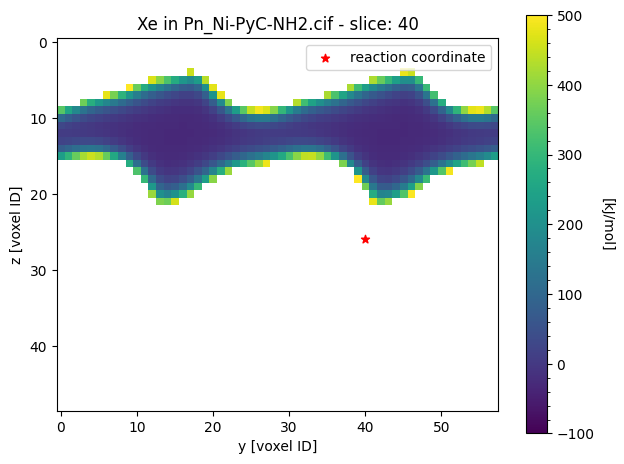

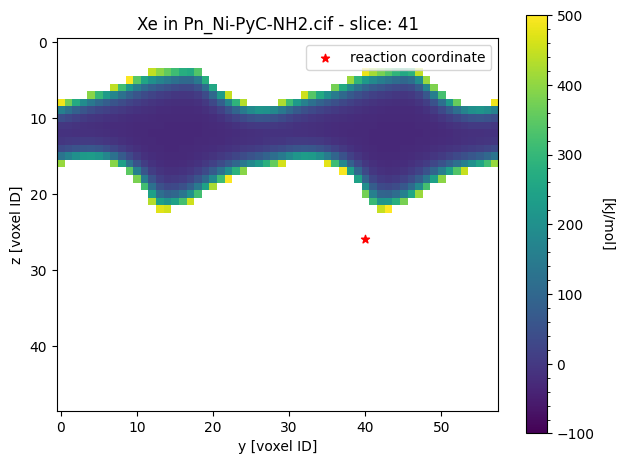

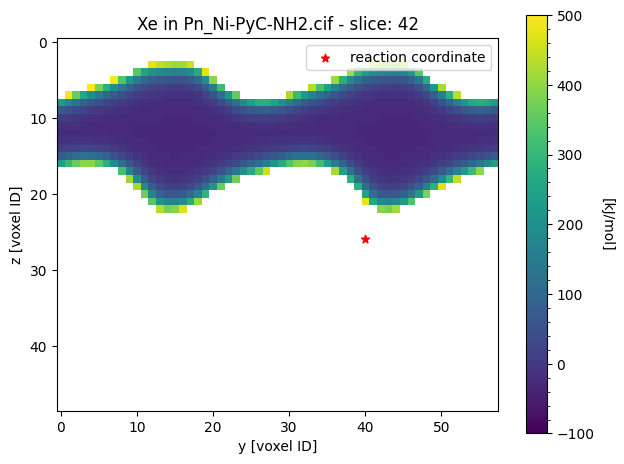

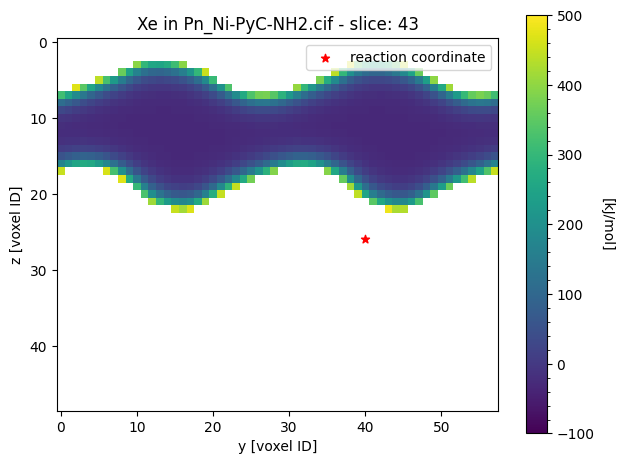

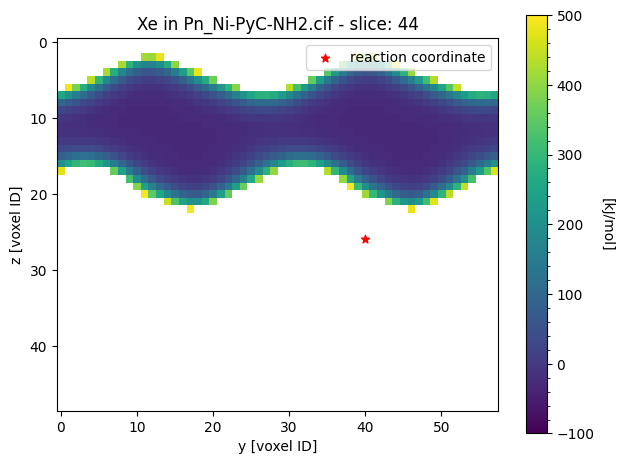

In [6]:
function plot_2d_energygrid_slices(grid::Grid, xtal::Crystal, 
                                   adsorbate::Molecule{Cart}; 
                                   energy_cutoff::Int64=500)
    for k in 1:grid.n_pts[1]
        data = deepcopy(grid.data[k, :, :])

        for i in 1:grid.n_pts[2]
            for j in 1:grid.n_pts[3]
                if data[i, j] > energy_cutoff
                    data[i, j] = Inf
                end
            end
        end

        # make heatmap
        fig, ax = subplots()
        ax.scatter(vox_id[2], vox_id[3], label="reaction coordinate", color="r", marker="*")
        ax.set_title("$(String(adsorbate.species)) in $(xtal.name) - slice: $k")
        ax.legend()

        im = ax.imshow(data[:, :], vmin=-100, vmax=energy_cutoff)
        ax.set_xlabel("y [voxel ID]")
        ax.set_ylabel("z [voxel ID]")

        # Create colorbar
        cbarlabel="[kJ/mol]"
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
        cbar.minorticks_on()

        fig.tight_layout();
        subdir_name = "$(String(adsorbate.species))_in_$(split(xtal.name, '.')[1])"
        savefig(joinpath(pwd(), "energygrid_slices", "$subdir_name/slice_$k.png"), dpi=600, format="png")
        fig.show();
    end
end


energy_cutoff = 500 # units: kJ/mol
plot_2d_energygrid_slices(grid, xtal, adsorbate; energy_cutoff=500)